**Problem 5a (German tank problem).** During WW2, the Allies discovered that German tanks carry consecutive serial numbers. Given a small collection of serial numbers of tanks that were captured or destroyed, they attempted to estimate the total number of tanks produced, and with great effect.

Formally, we a given a sample $X_1,\ldots,X_n$ from a uniform distribution over $\{1,\ldots,M\}$ and we want to estimate $M$. One obvious unbiased estimator is $$\hat{M}_1 = \frac{\sum_{i=1}^n X_i}{n} \cdot 2 - 1.$$
However, there are other options, notably $$\hat{M}_2 = \max\{X_1,\ldots,X_n\} \cdot \frac{n+1}{n}-1.$$

In this problem, your goal is to:
 * Verify empirically that the second estimator is indeed unbiased (this will also be proved formally in the class).
 * Decide which of the two estimators is more efficient (has lower variance).
 
**Note:** For the second estimator to be unbiased, the sampling has to be without replacement. This is also more realistic in the tank problem context.

**Problem 5b (Testing a sampler).** In this problem we will attempt to check whether the sampler we created in **Problem 2c** works correctly. To this end we will use a chi-squared goodness-of-fit test. This test works as follows:
 * Let $p_1,\ldots,p_d$ be the date frequencies as in the text file, scaled down to sum up to 1.
 * Use the sampler to generate a sample of dates. Let $c_1,\ldots,c_d$ be the observed counts, and let $f_i=Np_i$ be the expected counts, where $N$ is the sample size. 
 * Compute the test statistic $$S = \sum_{i=1}^d \frac{\left(c_i-f_i\right)^2}{f_i}.$$
 * Our base assumption (the null hypothesis) $H_0$ is that our sampler works correctly. If $H_0$ is true AND if the expected count for each bucket is large enough, then $S$ has (approximately) a $\chi^2$ distribution with $d-1$ degrees of freedom. 
 * Look up how likely is getting an $S$ value as large as the one you obtained if it has that distribution, i.e. the $p$-value. To do this use **scipy.stats.chi2.cdf**. If this value turns out smaller than the assumed threshold, e.g. $0.05$, we reject $H_0$. Otherwise we do not (we support $H_0$), but this does not mean $H_0$ is proved!
 * We mentioned earlier that expected counts for the buckets need to be large enough. "Large enough" assumption here is used to guarantee that $c_i$ are distributed approximately normally. Typically one requires that all counts are at least $5$. This is not the case in our problem (unless we take a huge sample) because of the errors in the data. The typical approach is to glue several buckets into one but this does not help in our case. Instead, ignore the erroneous dates when computing $c_i$ and $f_i$ and run the test again (on the same sample!). Remember to use a different number of degrees of freedom. Compare the results. 
 * Perform the same test using **scipy.stats.chisquare** and compare the results.

mean =  189479.94086021505
Sample


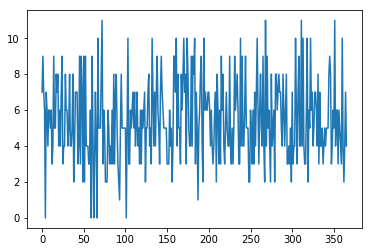

Real


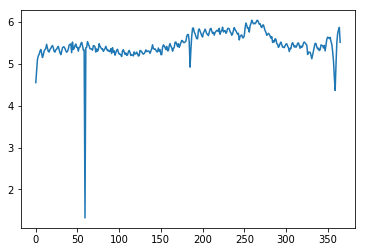

In [12]:
%matplotlib inline

#pip install bintrees
from bintrees import FastAVLTree
import numpy as np
import matplotlib.pyplot as plt
import scipy



def square_hist(data, generations):
    #Indices of properies stored in mutable 4-tuple
    POS = 0 
    H = 1
    MIX_POS = 2

    
    def vectorized_sample(count, squared, mean):
        mat = np.transpose(squared[np.random.randint(low = 0, high = len(squared), size=count)])
        R = mean * np.random.ranf(size = count)
        I = mat[POS]
        J = mat[MIX_POS]
        X = mat[H]
        D = X - R #difference of random value and height
        D = D / np.absolute(D) #Vec of -1s and 1s
        DI = (1 + D) / 2 #Vec of 1s and 0s where 1 denotes value from I
        DJ = 1 - DI #(negation of DI) Vec of 1s and 0s where 1 denotes value from J
        return (I * DI) + (J * DJ)
    
    
    def preprocess(data):
        mean = np.mean(data)
        print("mean = ", mean)
        tree = FastAVLTree()
        arr = []
        count = len(data)
        for i in range(0, count):
            tree.insert((data[i], i+1), [i, data[i], -1])
        while len(tree) >= 2:
            (k, maximal) = tree.pop_max()
            (k2, minimal) = tree.pop_min()
            if (minimal[H] < mean):
                diff = mean - minimal[H]
                minimal[MIX_POS] = maximal[POS]
                tree.insert((maximal[H] - diff, len(tree) + 1 ), [maximal[POS], maximal[H] - diff, -1])
            arr.append(minimal)
            
        if (len(tree) > 0):
            (k, last) = tree.pop_max()
            arr.append(last)
        return np.array(arr)
    
    squared_hist = preprocess(data)
    generated = vectorized_sample(generations, squared_hist, np.mean(data))
    ans = np.zeros(len(data))
    for g in range(0, len(generated)):
        ans[int(generated[g])] += 1
    return ans;


def show_both(sampled_data, real_data):
    print("Sample")
    plt.plot(sampled_data)
    plt.show()
    print("Real")
    plt.plot(real_data)
    plt.show()
    
def pmf(freq):
    return freq/np.sum(freq)

def my_chisquare(observed_values,expected_values):
    test_statistic=0
    for observed, expected in zip(observed_values, expected_values):
        test_statistic+=(float(observed)-float(expected))**2/float(expected)
    return test_statistic

def compute_s(exp, sampled, repeat):
    return np.sum(np.array([(sampled[i] - exp[i])**2/exp[i] for i in range(0, len(sampled))]))


def filter_errors(smp, exp, raw):
    fsmp = np.zeros(len(smp))
    fexp = np.zeros(len(smp))
    ctr = 0;
    for i in range(len(raw)):
        if (raw[i] > 1000):
            fsmp[ctr] = smp[i]
            fexp[ctr] = exp[i]
            ctr += 1
    return (fsmp[:ctr], fexp[:ctr])
    

SAMPLE_COUNT = 2000
raw_data = np.squeeze(np.asarray(np.genfromtxt('../lab1/us_births_69_88.csv', delimiter=',')[1:,2:]))
sample_raw = square_hist(raw_data, SAMPLE_COUNT)
expected_raw = pmf(raw_data) * SAMPLE_COUNT
sample, expected = filter_errors(sample_raw, expected_raw, raw_data)
show_both(sample, expected)




In [11]:
import scipy.stats
from scipy.stats import chisquare



# Change the value of 

mch = my_chisquare(sample, expected)
print(my_chisquare(sample, expected))
print(scipy.stats.chi2.cdf(mch, len(sample)-1))
print(scipy.stats.chisquare(sample, f_exp=expected))



343.06005385998725
0.210670755366769
Power_divergenceResult(statistic=343.06005385998736, pvalue=0.7893292446332298)


** Problem 5c (Chi-square independence test).** 
You are given the results of IPSOS exit polls for 2015 parliamentary elections in Poland in table **data**. Decide if we can assume that gender has no effect on voting preferences. To this end:
 * Compute row totals $r_i$, column totals $c_j$, and overall total $N$.
 * If the variables are independent, we expect to see $f_{ij} = r_i c_j / N$ in $i$-th row $j$-th column.
 * Compute the test statistic as before, i.e. $$ S = \sum_{ij} \frac{\left(f_{ij}-X_{ij}\right)^2}{f_{ij}}.$$
 * Again test vs $\chi^2$ CDF. However, if the variables are independent, we only have $r-1+c-1$ degrees of freedom here (we only need to know the row and column totals).
 * One obvious offender is the KORWiN party, try removing the last column and repeating the experiment.
 
**Note:** This kind of data is (to the best of our knowledge) not available online. It has been recreated based on
online infographics and other tidbits of information available online. It is definitely not completely accurate, hopefully it is not very far off. Moreover, exit polls do not necessary reflect the actual distribution of the population.

In [2]:
import numpy as np
# Rows: women, men
# Columns: PiS, PO, Kukiz, Nowoczesna, Lewica, PSL, Razem, KORWiN
#data = np.array([ [39.7,26.4,7.5,7.1,6.6,5.0,4.2,2.8], 
#                  [38.5,20.3,10.6,7.1,6.6,5.4,3.5,7.1]])
data = np.array([[ 17508, 11642,  3308,  3131,  2911,  2205,  1852, 1235],
 [ 17672,  9318,  4865,  3259,  3029,  2479,  1606, 3259]])

**Problem 5d (two-sample t-test).** We have two versions of a randomized optimization algorithm. In the table below you can find the objective function values for $n=20$ solutions found by each algorithm. Our goal is to decide if one of the algorithms is better than the other (i.e. finds solutions with higher values). We can proceed as follows:
 * Compute the means $M_1,M_2$. We need to decide if the difference $M_1-M_2$ is significant.
 * We estimate the standard deviation of $M_1-M_2$. Show that this is equal to $\sqrt{n(\sigma_1^2+\sigma_2^2)}$, where $\sigma_i$ is the standard deviation of the value found by the algorithm $i$. We can estimate this by $D=\sqrt{n(\hat{\sigma_1^2}+\hat{\sigma_2^2})}$ where $\hat{\sigma_i^2}$ is an unbiased estimate of the variance of $i$-th algorithm.
 * Now compute $\frac{M_1-M_2}{D}$. If the real values of $\sigma_i$ are equal, i.e. $\sigma_1=\sigma_2$, then it can be shown that this has a $t$-distribution with $2n-2$ degrees of freedom. 
 * Use **scipy.stats.t.cdf** to compute the p-value and decide if we can reject the null hyphotesis of the means being equal. Note that in our case the probability of getting a difference "at least as large as the one we got" has to include deviations in both directions!

In [4]:
import numpy as np
data=np.array([ [98.67573, 100.77983, 101.35478,  98.50285,  99.14984, 
      100.64105,  98.37170, 100.24933, 99.54994, 100.79508, 
      101.14978, 101.32538, 100.44573, 97.60020, 97.78547,  
      98.88703,  99.06794, 100.65313, 100.30297, 100.26311],
       [99.96234, 99.94943, 99.58779, 100.52263, 101.58972,
        101.78411, 100.09874, 100.99211, 101.93214, 100.61749,
        100.46854,  99.19030, 101.28412, 100.70897, 99.83988,
        100.24668,  99.38278,  99.82720,  97.55918, 100.63128]])